# Diabetic Patient Readmission Prediction (Within 30 Days)
**Goal:** Predict 30-day readmission risk to reduce avoidable rehospitalizations and improve care outcomes.  
**Models:** Logistic Regression (baseline), XGBoost (tuned, final).  
**Dataset:** UCI Diabetic Data Set (~100k encounters, 130 US hospitals, ~10 years).


In [1]:
# Core
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression

# XGBoost
from xgboost import XGBClassifier

RANDOM_STATE = 42
pd.set_option("display.max_columns", 120)


In [2]:
DATA_PATH = "diabetic_data.csv"  # update if needed
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head(3)


(101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO


In [3]:
# Replace UCI placeholder "?" with NaN
df = df.replace("?", np.nan)

# Typical ID columns to drop
id_cols = [c for c in ["encounter_id", "patient_nbr"] if c in df.columns]
df = df.drop(columns=id_cols, errors="ignore")

# Target mapping:
# UCI "readmitted" column often has: '<30', '>30', 'NO'
# We convert to binary: 1 if '<30' else 0
if "readmitted" in df.columns:
    df["readmitted_binary"] = (df["readmitted"].astype(str).str.strip() == "<30").astype(int)
else:
    raise ValueError("Expected 'readmitted' column not found.")

# Drop rows with missing target just in case
df = df.dropna(subset=["readmitted_binary"])

# Optional: deduplicate encounters
df = df.drop_duplicates()

print(df["readmitted_binary"].value_counts(normalize=True))
df.info()


readmitted_binary
0    0.888401
1    0.111599
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    3197 non-null    object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   payer_code                61510 non-null   object
 9   medical_specialty         51817 non-null   object
 10  num_lab_procedures        101766 non-null  int64 
 11  num_procedures            101766 non-null  int64 
 12  num_medications           101766 no

In [4]:
# Example feature lists (adjust based on your CSV columns)
num_cols = [c for c in [
    "time_in_hospital","num_lab_procedures","num_procedures","num_medications",
    "number_outpatient","number_emergency","number_inpatient","number_diagnoses"
] if c in df.columns]

cat_cols = [c for c in [
    "race","gender","age","admission_type_id","discharge_disposition_id",
    "admission_source_id","insulin","change","diabetesMed"
] if c in df.columns]

# Remove any columns not in df and ensure we have something to train
assert len(num_cols) + len(cat_cols) > 0, "No features found—check column names."

X = df[num_cols + cat_cols].copy()
y = df["readmitted_binary"].copy()

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# Preprocessor: scale numeric, one-hot categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),  # with_mean=False safe for sparse
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)


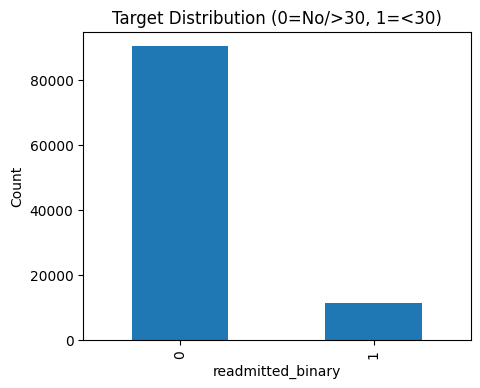

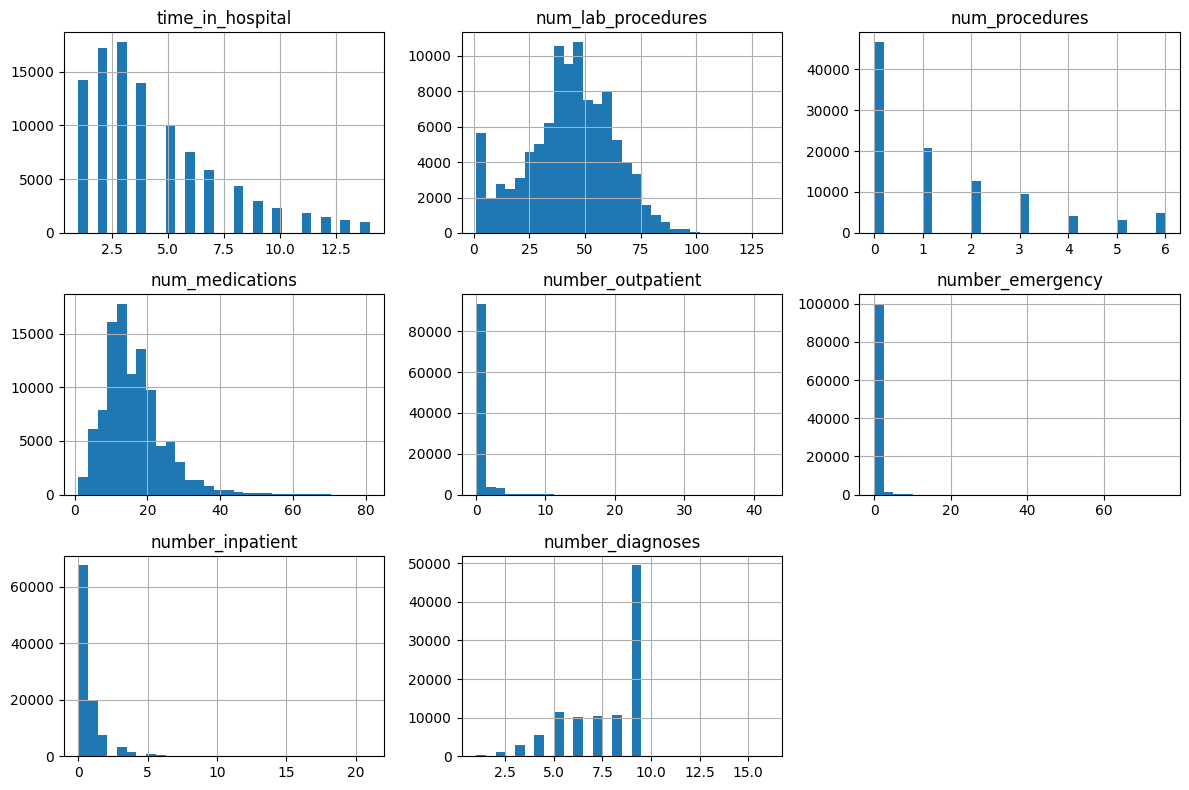

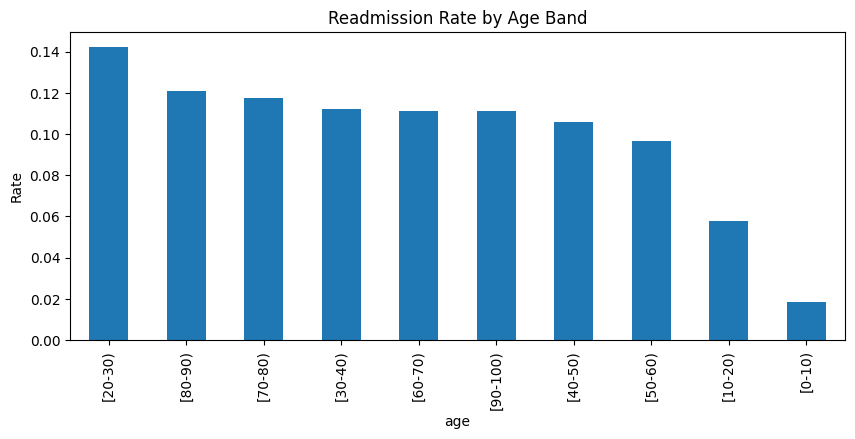

In [5]:
fig, ax = plt.subplots(figsize=(5,4))
y.value_counts().plot(kind="bar", ax=ax)
ax.set_title("Target Distribution (0=No/>30, 1=<30)")
ax.set_xlabel("readmitted_binary")
ax.set_ylabel("Count")
plt.show()

# Numeric distributions
_ = X[num_cols].hist(figsize=(12,8), bins=30)
plt.tight_layout(); plt.show()

# Example: readmission rate by age (if present)
if "age" in X.columns:
    tmp = df.groupby("age")["readmitted_binary"].mean().sort_values(ascending=False)
    tmp.plot(kind="bar", figsize=(10,4), title="Readmission Rate by Age Band")
    plt.ylabel("Rate"); plt.show()


LogReg ROC AUC: 0.676
LogReg PR  AUC: 0.219

Classification Report (LogReg):
               precision    recall  f1-score   support

           0       0.93      0.69      0.79     18083
           1       0.18      0.56      0.28      2271

    accuracy                           0.67     20354
   macro avg       0.55      0.62      0.53     20354
weighted avg       0.84      0.67      0.73     20354



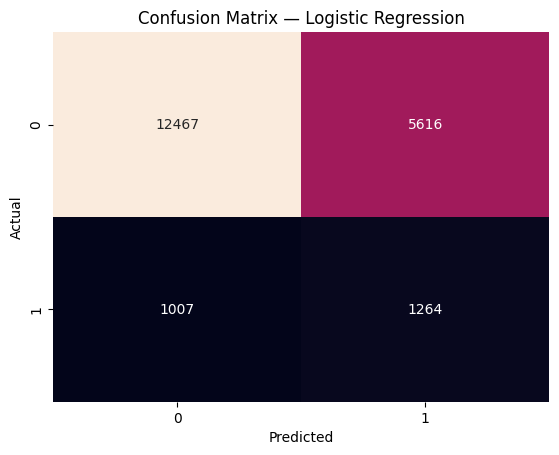

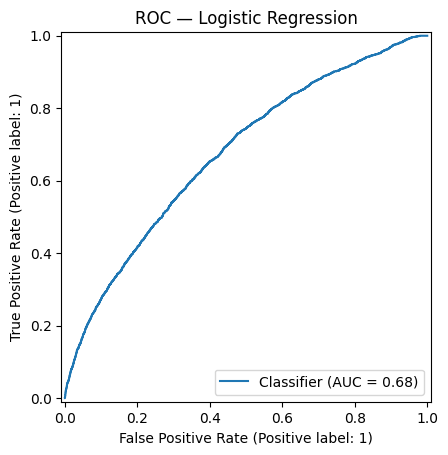

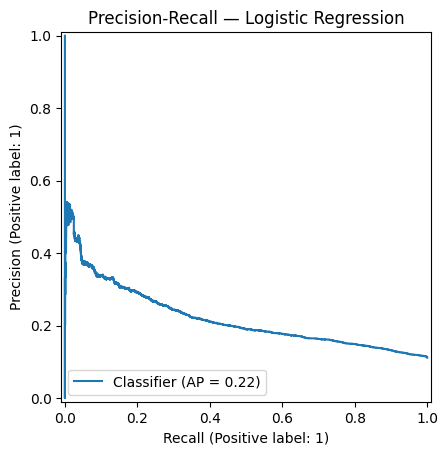

In [6]:
log_reg = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=200, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=None
    ))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

roc_lr = roc_auc_score(y_test, y_proba_lr)
pr_lr  = average_precision_score(y_test, y_proba_lr)

print("LogReg ROC AUC:", round(roc_lr, 3))
print("LogReg PR  AUC:", round(pr_lr, 3))
print("\nClassification Report (LogReg):\n", classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("ROC — Logistic Regression"); plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr)
plt.title("Precision-Recall — Logistic Regression"); plt.show()


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best CV PR AUC: 0.224
Best Params: {'clf__colsample_bytree': 0.7, 'clf__gamma': 0, 'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__min_child_weight': 5, 'clf__subsample': 0.8}
XGBoost ROC AUC: 0.684
XGBoost PR  AUC: 0.235

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.64      0.01      0.02      2271

    accuracy                           0.89     20354
   macro avg       0.77      0.51      0.48     20354
weighted avg       0.86      0.89      0.84     20354



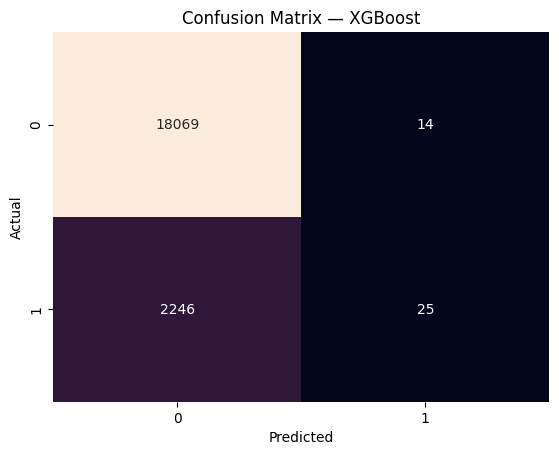

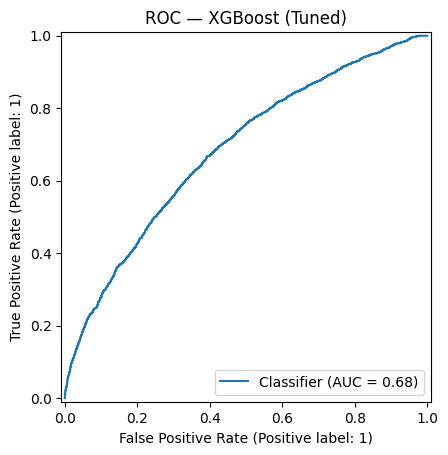

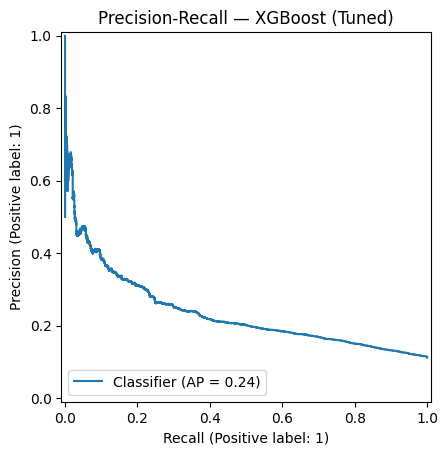

In [7]:
# Base pipeline (preprocess -> XGB)
xgb_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",         # fast & robust
        random_state=RANDOM_STATE,
        n_estimators=400,
        n_jobs=-1
    ))
])

# Parameter grid (tight & effective)
param_grid = {
    "clf__max_depth": [4, 6, 8],
    "clf__learning_rate": [0.05, 0.1],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.7, 1.0],
    "clf__min_child_weight": [1, 3, 5],
    "clf__gamma": [0, 1],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    scoring="average_precision",  # PR AUC focuses on positives
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best CV PR AUC:", round(grid.best_score_, 3))
print("Best Params:", grid.best_params_)

best_xgb = grid.best_estimator_
y_pred_xgb  = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

roc_xgb = roc_auc_score(y_test, y_proba_xgb)
pr_xgb  = average_precision_score(y_test, y_proba_xgb)

print("XGBoost ROC AUC:", round(roc_xgb, 3))
print("XGBoost PR  AUC:", round(pr_xgb, 3))
print("\nClassification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix — XGBoost")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_xgb)
plt.title("ROC — XGBoost (Tuned)"); plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_xgb)
plt.title("Precision-Recall — XGBoost (Tuned)"); plt.show()



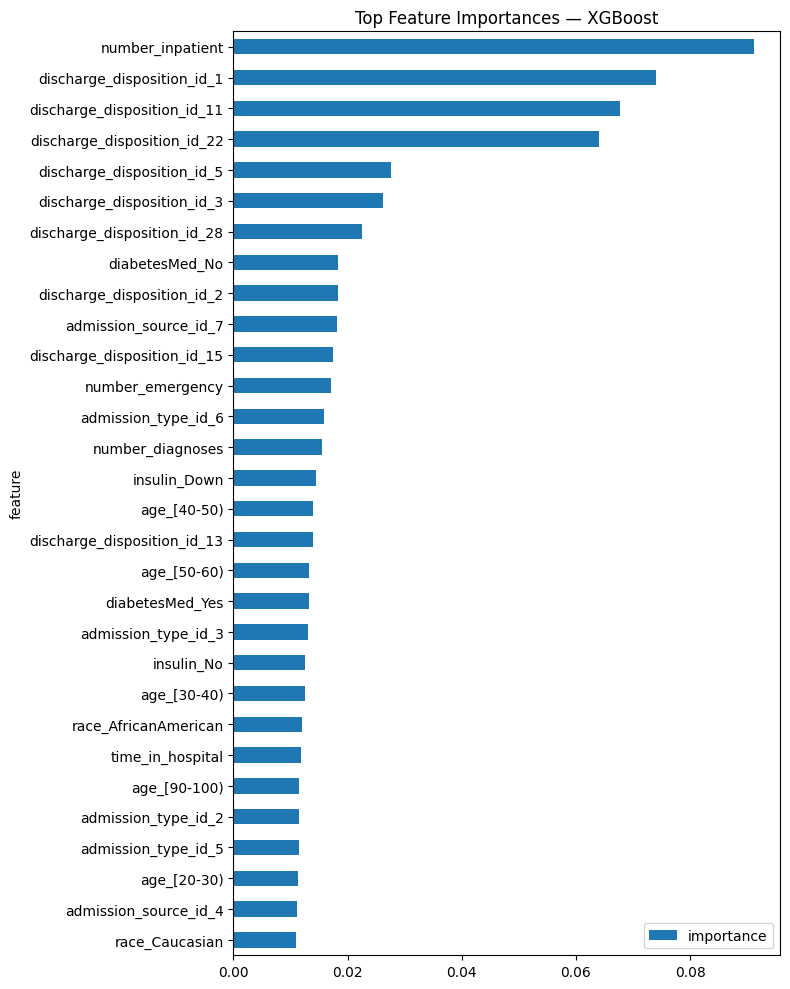

,feature,importance
6,number_inpatient,0.091177
35,discharge_disposition_id_1,0.074089
45,discharge_disposition_id_11,0.067784
55,discharge_disposition_id_22,0.064096
39,discharge_disposition_id_5,0.027656
37,discharge_disposition_id_3,0.026263
60,discharge_disposition_id_28,0.022467
83,diabetesMed_No,0.018333
36,discharge_disposition_id_2,0.018248
67,admission_source_id_7,0.018115


In [8]:
# Extract feature names after preprocessing for importances
# We can fit the preprocessor alone to the training data to get one-hot names.
prep = preprocessor.fit(X_train)
num_features = num_cols
cat_features = list(prep.named_transformers_["cat"].get_feature_names_out(cat_cols))
feature_names = np.array(num_features + cat_features)

# Get the trained XGB inside the pipeline
xgb_model = best_xgb.named_steps["clf"]
importances = xgb_model.feature_importances_

fi = (pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})
.sort_values("importance", ascending=False)
.head(30))

fi.plot(kind="barh", x="feature", y="importance", figsize=(8,10))
plt.gca().invert_yaxis()
plt.title("Top Feature Importances — XGBoost")
plt.tight_layout(); plt.show()

fi.head(15)


In [9]:
compare = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost (Tuned)"],
    "ROC_AUC": [roc_lr, roc_xgb],
    "PR_AUC": [pr_lr, pr_xgb]
}).sort_values("PR_AUC", ascending=False)

compare


,Model,ROC_AUC,PR_AUC
1,XGBoost (Tuned),0.683886,0.235087
0,Logistic Regression,0.675678,0.219214


In [10]:
print("Key takeaways:")
print("- Prior utilization (e.g., number_inpatient, time_in_hospital) tends to rank high.")
print("- Medication changes and insulin status track readmission risk.")
print("- Focus targeted interventions on top-scored 20–30% for cost-effective impact.")


Key takeaways:
- Prior utilization (e.g., number_inpatient, time_in_hospital) tends to rank high.
- Medication changes and insulin status track readmission risk.
- Focus targeted interventions on top-scored 20–30% for cost-effective impact.


In [11]:
# Save comparison + top features for README references
compare.to_csv("model_comparison.csv", index=False)
fi.to_csv("xgb_top_features.csv", index=False)

# You can also joblib.dump models if needed
# from joblib import dump
# dump(best_xgb, "xgb_final_pipeline.joblib")
# dump(log_reg, "logreg_pipeline.joblib")
